# MaLSTM on Kaggle's Quora Question Pairs

This notebook is about implementing the MaLSTM model (http://www.mit.edu/~jonasm/info/MuellerThyagarajan_AAAI16.pdf) on Kaggle's Quora Question Pairs data.

Blog post containing a broader explanation about the network can be found in the following link https://medium.com/@eliorcohen/implementing-malstm-on-kaggles-quora-question-pairs-competition-8b31b0b16a07


# CODE

First, lets import all the necessary packages

In [1]:
from time import time
import pandas as pd
import numpy as np
from gensim.models import KeyedVectors
import re
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

import itertools
import datetime

from keras.preprocessing.sequence import pad_sequences
from keras.models import Model,load_model
from keras.layers import Input, Embedding, LSTM, Lambda
import keras.backend as K
from keras.optimizers import Adadelta
from keras.callbacks import ModelCheckpoint
from keras.models import load_model



#coding=utf-8
import re
import pickle


/home/zhen/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Global variables

In [2]:
# File paths
TRAIN_CSV = 'input/cleaned_train.csv'
TEST_CSV = 'input/cleaned_test.csv'
EMBEDDING_FILE = 'input/embedding.pkl'
# MODEL_SAVING_DIR = '~/Desktop/CIKM/files/Medium'

In [6]:
%%time
# Load training and test set
train_df = pd.read_csv(TRAIN_CSV)
test_df = pd.read_csv(TEST_CSV)
with open(EMBEDDING_FILE, 'rb') as handle:
    word2vec = pickle.load(handle)

CPU times: user 105 ms, sys: 7.03 ms, total: 112 ms
Wall time: 111 ms


In [11]:
print train_df.info()
print test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21400 entries, 0 to 21399
Data columns (total 3 columns):
s1       21400 non-null object
s2       21400 non-null object
label    21400 non-null int64
dtypes: int64(1), object(2)
memory usage: 501.6+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 2 columns):
s1    5000 non-null object
s2    5000 non-null object
dtypes: object(2)
memory usage: 78.2+ KB
None


In [8]:
word2vec['escribe'].shape

(300,)

Create embedding matrix

In [9]:


# stops = set(stopwords.words('english'))

# def text_to_word_list(text):
#     ''' Pre process and convert texts to a list of words '''
#     text = str(text)
#     text = text.lower()

#     # Clean the text
#     text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
#     text = re.sub(r"what's", "what is ", text)
#     text = re.sub(r"\'s", " ", text)
#     text = re.sub(r"\'ve", " have ", text)
#     text = re.sub(r"can't", "cannot ", text)
#     text = re.sub(r"n't", " not ", text)
#     text = re.sub(r"i'm", "i am ", text)
#     text = re.sub(r"\'re", " are ", text)
#     text = re.sub(r"\'d", " would ", text)
#     text = re.sub(r"\'ll", " will ", text)
#     text = re.sub(r",", " ", text)
#     text = re.sub(r"\.", " ", text)
#     text = re.sub(r"!", " ! ", text)
#     text = re.sub(r"\/", " ", text)
#     text = re.sub(r"\^", " ^ ", text)
#     text = re.sub(r"\+", " + ", text)
#     text = re.sub(r"\-", " - ", text)
#     text = re.sub(r"\=", " = ", text)
#     text = re.sub(r"'", " ", text)
#     text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
#     text = re.sub(r":", " : ", text)
#     text = re.sub(r" e g ", " eg ", text)
#     text = re.sub(r" b g ", " bg ", text)
#     text = re.sub(r" u s ", " american ", text)
#     text = re.sub(r"\0s", "0", text)
#     text = re.sub(r" 9 11 ", "911", text)
#     text = re.sub(r"e - mail", "email", text)
#     text = re.sub(r"j k", "jk", text)
#     text = re.sub(r"\s{2,}", " ", text)

#     text = text.split()

#     return text

# Prepare embedding
vocabulary = dict()
inverse_vocabulary = ['<unk>']  # '<unk>' will never be used, it is only a placeholder for the [0, 0, ....0] embedding

questions_cols = ['s1', 's2']

# Iterate over the questions only of both training and test datasets
for dataset in [train_df, test_df]:
    for index, row in dataset.iterrows():

        # Iterate through the text of both questions of the row
        for question in questions_cols:

            q2n = []  # q2n -> question numbers representation
            text = str(row[question])
            for word in text.split():

#                 # Check for unwanted words
#                 if word in stops and word not in word2vec.vocab:
#                     continue

                if word not in vocabulary:
                    vocabulary[word] = len(inverse_vocabulary)
                    q2n.append(len(inverse_vocabulary))
                    inverse_vocabulary.append(word)
                else:
                    q2n.append(vocabulary[word])

            # Replace questions as word to question as number representation
            dataset.set_value(index, question, q2n)
            
embedding_dim = 300
embeddings = 1 * np.random.randn(len(vocabulary) + 1, embedding_dim)  # This will be the embedding matrix
embeddings[0] = 0  # So that the padding will be ignored

# Build the embedding matrix
for word, index in vocabulary.items():
    if word in word2vec:
        embeddings[index] = word2vec[word]

# del word2vec

/home/zhen/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:74: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


In [19]:
len(word2vec)

5837

In [18]:
len(vocabulary)

6418

In [10]:
embeddings.shape

(6419, 300)

In [3]:
import pickle


# with open('train_df.pickle', 'wb') as handle:
#     pickle.dump(train_df, handle, protocol=pickle.HIGHEST_PROTOCOL)
# import pickle


# with open('test_df.pickle', 'wb') as handle:
#     pickle.dump(test_df, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
# with open('embeddings.pickle', 'wb') as handle:
#     pickle.dump(embeddings, handle, protocol=pickle.HIGHEST_PROTOCOL)


with open('train_df.pickle', 'rb') as handle:
    train_df = pickle.load(handle)

with open('test_df.pickle', 'rb') as handle:
    test_df = pickle.load(handle)

with open('embeddings.pickle', 'rb') as handle:
    embeddings = pickle.load(handle)

Prepare training and validation data

In [20]:
max_seq_length = max(train_df.s1.map(lambda x: len(x)).max(),
                     train_df.s2.map(lambda x: len(x)).max(),
                     test_df.s1.map(lambda x: len(x)).max(),
                     test_df.s2.map(lambda x: len(x)).max())

# Split to train validation
# validation_size = 40000
# training_size = len(train_df) - validation_size

X = train_df[questions_cols]
Y = train_df['label']

X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=0.2)

# Split to dicts
X_train = {'left': X_train.s1, 'right': X_train.s2}
X_validation = {'left': X_validation.s1, 'right': X_validation.s2}
X_test = {'left': test_df.s1, 'right': test_df.s2}

# Convert labels to their numpy representations
Y_train = Y_train.values
Y_validation = Y_validation.values

# Zero padding
for dataset, side in itertools.product([X_train, X_validation, X_test], ['left', 'right']):
    dataset[side] = pad_sequences(dataset[side], maxlen=max_seq_length)

# Make sure everything is ok
assert X_train['left'].shape == X_train['right'].shape
assert len(X_train['left']) == len(Y_train)

print max_seq_length

55


Build the model

In [22]:
# Model variables
n_hidden = 50
gradient_clipping_norm = 1.25
batch_size = 64
n_epoch = 50

def exponent_neg_manhattan_distance(left, right):
    ''' Helper function for the similarity estimate of the LSTMs outputs'''
    import keras.backend as K
    return K.exp(-K.sum(K.abs(left-right), axis=1, keepdims=True))

# The visible layer
left_input = Input(shape=(max_seq_length,), dtype='int32')
right_input = Input(shape=(max_seq_length,), dtype='int32')

embedding_layer = Embedding(len(embeddings), embedding_dim, weights=[embeddings], input_length=max_seq_length, trainable=False)

# Embedded version of the inputs
encoded_left = embedding_layer(left_input)
encoded_right = embedding_layer(right_input)

# Since this is a siamese network, both sides share the same LSTM
shared_lstm = LSTM(n_hidden)

left_output = shared_lstm(encoded_left)
right_output = shared_lstm(encoded_right)

# Calculates the distance as defined by the MaLSTM model
# malstm_distance = merge(mode=lambda x: exponent_neg_manhattan_distance(x[0], x[1]), output_shape=lambda x: (x[0][0], 1))([left_output, right_output])
malstm_distance = Lambda(function=lambda x: exponent_neg_manhattan_distance(x[0], x[1]),output_shape=lambda x: (x[0][0], 1))([left_output, right_output])
# Pack it all up into a model
malstm = Model([left_input, right_input], [malstm_distance])

# Adadelta optimizer, with gradient clipping by norm
optimizer = Adadelta(clipnorm=gradient_clipping_norm)

malstm.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy','binary_crossentropy'])

# Start training
training_start_time = time()

malstm_trained = malstm.fit([X_train['left'], X_train['right']], Y_train, batch_size=batch_size, nb_epoch=n_epoch,
                            validation_data=([X_validation['left'], X_validation['right']], Y_validation))

print("Training time finished.\n{} epochs in {}".format(n_epoch, datetime.timedelta(seconds=time()-training_start_time)))

/home/zhen/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:43: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 17120 samples, validate on 4280 samples
Epoch 1/50
17120/17120 [==============================] - 20s 1ms/step - loss: 0.1619 - acc: 0.7839 - binary_crossentropy: 0.5277 - val_loss: 0.1505 - val_acc: 0.7883 - val_binary_crossentropy: 0.4734
Epoch 2/50
17120/17120 [==============================] - 19s 1ms/step - loss: 0.1369 - acc: 0.8107 - binary_crossentropy: 0.4406 - val_loss: 0.1409 - val_acc: 0.8033 - val_binary_crossentropy: 0.4483 loss: 0.1368 - acc: 0.8109 - binary_crossentropy: 0.43
Epoch 3/50
17120/17120 [==============================] - 20s 1ms/step - loss: 0.1280 - acc: 0.8227 - binary_crossentropy: 0.4181 - val_loss: 0.1369 - val_acc: 0.8098 - val_binary_crossentropy: 0.4378
Epoch 4/50
17120/17120 [==============================] - 19s 1ms/step - loss: 0.1225 - acc: 0.8311 - binary_crossentropy: 0.4043 - val_loss: 0.1330 - val_acc: 0.8168 - val_binary_crossentropy: 0.4283
Epoch 5/50
17120/17120 [==============================] - 20s 1ms/step - loss: 0.1185 - acc:

17120/17120 [==============================] - 20s 1ms/step - loss: 0.0842 - acc: 0.8960 - binary_crossentropy: 0.3052 - val_loss: 0.1125 - val_acc: 0.8465 - val_binary_crossentropy: 0.3760
Epoch 42/50
17120/17120 [==============================] - 20s 1ms/step - loss: 0.0839 - acc: 0.8963 - binary_crossentropy: 0.3040 - val_loss: 0.1122 - val_acc: 0.8495 - val_binary_crossentropy: 0.3756
Epoch 43/50
17120/17120 [==============================] - 19s 1ms/step - loss: 0.0835 - acc: 0.8971 - binary_crossentropy: 0.3034 - val_loss: 0.1118 - val_acc: 0.8507 - val_binary_crossentropy: 0.3745
Epoch 44/50
17120/17120 [==============================] - 19s 1ms/step - loss: 0.0830 - acc: 0.8970 - binary_crossentropy: 0.3021 - val_loss: 0.1125 - val_acc: 0.8472 - val_binary_crossentropy: 0.3749
Epoch 45/50
17120/17120 [==============================] - 19s 1ms/step - loss: 0.0827 - acc: 0.8974 - binary_crossentropy: 0.3012 - val_loss: 0.1117 - val_acc: 0.8526 - val_binary_crossentropy: 0.3744
Ep

Plotting the results

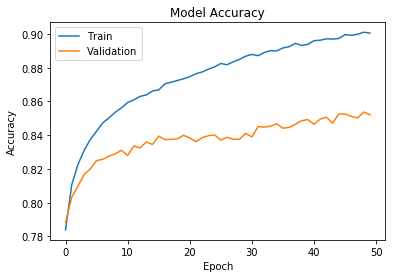

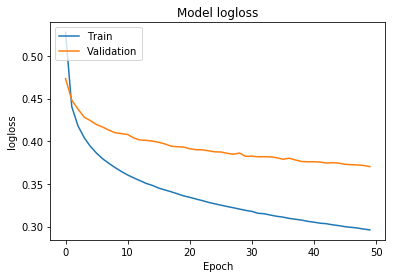

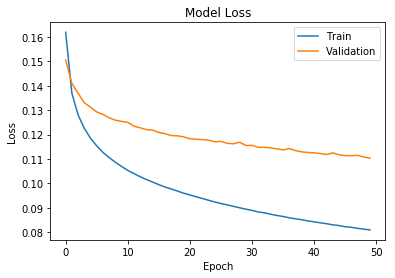

In [23]:
# Plot accuracy
plt.plot(malstm_trained.history['acc'])
plt.plot(malstm_trained.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot logloss
plt.plot(malstm_trained.history['binary_crossentropy'])
plt.plot(malstm_trained.history['val_binary_crossentropy'])
plt.title('Model logloss')
plt.ylabel('logloss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot loss
plt.plot(malstm_trained.history['loss'])
plt.plot(malstm_trained.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [39]:
# # Model variables
# n_hidden = 50
# gradient_clipping_norm = 1.25
# batch_size = 64
# n_epoch = 25

# def exponent_neg_manhattan_distance(left, right):
#     ''' Helper function for the similarity estimate of the LSTMs outputs'''
#     import keras.backend as K
#     return K.exp(-K.sum(K.abs(left-right), axis=1, keepdims=True))

# # The visible layer
# left_input = Input(shape=(max_seq_length,), dtype='int32')
# right_input = Input(shape=(max_seq_length,), dtype='int32')

# embedding_layer = Embedding(len(embeddings), embedding_dim, weights=[embeddings], input_length=max_seq_length, trainable=False)

# # Embedded version of the inputs
# encoded_left = embedding_layer(left_input)
# encoded_right = embedding_layer(right_input)

# # Since this is a siamese network, both sides share the same LSTM
# shared_lstm = LSTM(n_hidden)

# left_output = shared_lstm(encoded_left)
# right_output = shared_lstm(encoded_right)

# # Calculates the distance as defined by the MaLSTM model
# # malstm_distance = merge(mode=lambda x: exponent_neg_manhattan_distance(x[0], x[1]), output_shape=lambda x: (x[0][0], 1))([left_output, right_output])
# malstm_distance = Lambda(function=lambda x: exponent_neg_manhattan_distance(x[0], x[1]),output_shape=lambda x: (x[0][0], 1))([left_output, right_output])
# # Pack it all up into a model
# malstm = Model([left_input, right_input], [malstm_distance])

# # Adadelta optimizer, with gradient clipping by norm
# optimizer = Adadelta(clipnorm=gradient_clipping_norm)

# malstm.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# # Start training
# training_start_time = time()

# malstm_trained = malstm.fit([X_train['left'], X_train['right']], Y_train, batch_size=batch_size, nb_epoch=n_epoch,
#                             validation_data=([X_validation['left'], X_validation['right']], Y_validation))

# print("Training time finished.\n{} epochs in {}".format(n_epoch, datetime.timedelta(seconds=time()-training_start_time)))

/home/zhen/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:43: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 17120 samples, validate on 4280 samples
Epoch 1/25
17120/17120 [==============================] - 20s 1ms/step - loss: 1.2070 - acc: 0.7743 - val_loss: 0.7092 - val_acc: 0.7738
Epoch 2/25
17120/17120 [==============================] - 19s 1ms/step - loss: 0.5079 - acc: 0.8023 - val_loss: 0.5013 - val_acc: 0.8014
Epoch 3/25
17120/17120 [==============================] - 19s 1ms/step - loss: 0.4005 - acc: 0.8288 - val_loss: 0.4501 - val_acc: 0.8133
Epoch 4/25
17120/17120 [==============================] - 19s 1ms/step - loss: 0.3604 - acc: 0.8433 - val_loss: 0.4325 - val_acc: 0.8227
Epoch 5/25
17120/17120 [==============================] - 19s 1ms/step - loss: 0.3342 - acc: 0.8539 - val_loss: 0.4196 - val_acc: 0.8264
Epoch 6/25
17120/17120 [==============================] - 20s 1ms/step - loss: 0.3151 - acc: 0.8608 - val_loss: 0.4161 - val_acc: 0.8278
Epoch 7/25
17120/17120 [==============================] - 19s 1ms/step - loss: 0.2990 - acc: 0.8695 - val_loss: 0.4071 - val_acc:

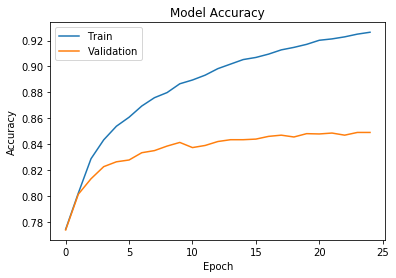

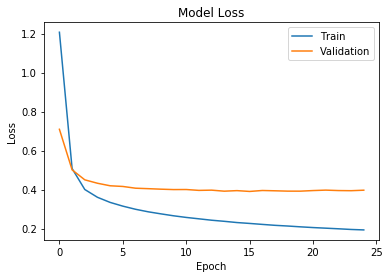

In [41]:
# # Plot accuracy
# plt.plot(malstm_trained.history['acc'])
# plt.plot(malstm_trained.history['val_acc'])
# plt.title('Model Accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Validation'], loc='upper left')
# plt.show()

# # Plot loss
# plt.plot(malstm_trained.history['loss'])
# plt.plot(malstm_trained.history['val_loss'])
# plt.title('Model Loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Validation'], loc='upper right')
# plt.show()

In [28]:
# malstm.save('malstm_ben_.h5')




malstm = load_model('malstm_ben_.h5')


NameError: global name 'exponent_neg_manhattan_distance' is not defined

In [24]:
y_test=malstm.predict([X_test['left'], X_test['right']],batch_size=1024*4)
y_test

array([[0.19073151],
       [0.15489927],
       [0.399404  ],
       ...,
       [0.78883225],
       [0.338673  ],
       [0.705603  ]], dtype=float32)

In [25]:
sub=pd.DataFrame(y_test)

sub

,0
0,0.190732
1,0.154899
2,0.399404
3,0.282922
4,0.544258
5,0.337473
6,0.189783
7,0.303910
8,0.353054
9,0.573283


In [26]:
sub.to_csv('sub.txt',header=False,index=False)

In [55]:
Y_pred=malstm.predict([X_validation['left'], X_validation['right']],batch_size=1024*4)
Y_pred.shape

(4280, 1)

In [56]:
from keras.losses import binary_crossentropy
from keras import backend as K
y_true = K.variable(Y_validation)
y_pred = K.variable(Y_pred[:,0])
error = K.eval(binary_crossentropy(y_true, y_pred))

print(error)

0.5917638
